# Capstone Project 

*Where to move in Toronto, Ontario*

## Table of contents
* [Getting the data](#section1)
* [Get close venues for each neighborhood](#section2)

## Imports

In [1]:
try:
    #Data processing
    import pandas as pd
    import numpy as np
    from geopy.geocoders import Nominatim
    import os
    from os.path import join
    import json

    #Webscraping
    import requests
    from bs4 import BeautifulSoup

    #Clustering
    from sklearn.cluster import KMeans
    from scipy.spatial.distance import cdist

    #Visualization
    import folium
    import matplotlib.cm as cm
    import matplotlib.colors as colors
    import matplotlib.pyplot as plt

except:
    print("Please install missing packages manually.")

## Classes

### style

In [2]:
# Make borough appear bold in map
class style:
   BOLD = '\033[1m'
   END = '\033[0m'

### my_dictionary

In [3]:
# Create a dictionary class
class my_dictionary(dict):

    # __init__ function
    def __init__(self):
        self = dict()
          
    # Function to add key:value
    def add(self, key, value):
        self[key] = value

## Collecting the data

In [4]:
URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
data  = requests.get(URL).text
soup = BeautifulSoup(data,"html5lib")

In [5]:
postal_codes_dict = {}
# Creating Dataframe from scraped data
for table_cell in soup.find_all('td'):
    try:
        postal_code = table_cell.p.b.text # get the postal code
        postal_code_investigate = table_cell.span.text
        neighborhoods_data = table_cell.span.text # get the rest of the data in the cell
        borough = neighborhoods_data.split('(')[0] # get the borough
        
        # if the cell is not assigned then ignore it
        if neighborhoods_data == 'Not assigned':
            neighborhoods = [] # which means that the borough hasn't got a neighborhood
        
        # else process the data and add it to the dictionary
        else:
            postal_codes_dict[postal_code] = {}
            
            try:
                neighborhoods = neighborhoods_data.split('(')[1]
            
                # remove parantheses from neighborhoods string
                neighborhoods = neighborhoods.replace('(', ' ')
                neighborhoods = neighborhoods.replace(')', ' ')

                neighborhoods_names = neighborhoods.split('/')
                neighborhoods_clean = ', '.join([name.strip() for name in neighborhoods_names])
            except:
                borough = borough.strip('\n')
                neighborhoods_clean = borough
 
            # add borough and neighborhood to dictionary
            postal_codes_dict[postal_code]['borough'] = borough
            postal_codes_dict[postal_code]['neighborhoods'] = neighborhoods_clean
    except:
        pass
    
# create an empty dataframe
columns = ['PostalCode', 'Borough', 'Neighborhood']
data = pd.DataFrame(columns=columns)

# populate dataframe with data from dictionary
for ind, postal_code in enumerate(postal_codes_dict):
    borough = postal_codes_dict[postal_code]['borough']
    neighborhood = postal_codes_dict[postal_code]['neighborhoods']
    data = data.append({"PostalCode": postal_code, 
                                "Borough": borough, 
                                "Neighborhood": neighborhood},
                                ignore_index=True)

data.shape

(103, 3)

In [6]:
data.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


## Visualize data on map for better understanding

### Add Latitude and Longitude

In [7]:
#load geodata (Latitude, Longitude) from csv
geodata = pd.read_csv("Geospatial_Coordinates.csv")

lat = []
long = []

for postalCode in data['PostalCode']:
    lat.append(geodata[geodata['Postal Code'] == postalCode]["Latitude"].values[0])
    long.append(geodata[geodata['Postal Code'] == postalCode]["Longitude"].values[0])

data['Latitude'] = lat
data['Longitude'] = long

In [8]:
# find coordinates to focus the map 
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### Create map

In [9]:
# create map of Toronto using latitude and longitude values
map_data = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(data['Latitude'], data['Longitude'], data['Borough'], data['Neighborhood']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=f"<i>{neighborhood}, <b>{borough}</b></i>",
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_data)  
    
map_data

<a id='section2'></a>
# Get close venues for each neighborhood

In this project i will only take a look at the general categories (e.g. restaurants) not subcategories like Asian-Restaurant.

## Get list of all possible venue categories through foursquare API

In [10]:
URL = "https://developer.foursquare.com/docs/build-with-foursquare/categories/"
response  = requests.get(URL)
soup = BeautifulSoup(response.content,"html5lib")

In [11]:
content = soup.find(class_="documentTemplate__Content-sc-5mpekp-0 bbBBoE")

categories = []

for item in content.ul.children:
    categories.append(item.div.h3.text)
    
categories.sort()
categories

['Arts & Entertainment',
 'College & University',
 'Event',
 'Food',
 'Nightlife Spot',
 'Outdoors & Recreation',
 'Professional & Other Places',
 'Residence',
 'Shop & Service',
 'Travel & Transport']

In [12]:
# store categories with matching category ID to acces foursquare API
categoriesDict = my_dictionary()

for item in content.ul.children:
    category = item.div.h3.text
    categoryID = item.div.p.text
    categoriesDict.add(category, categoryID)

categoriesDict

{'Arts & Entertainment': '4d4b7104d754a06370d81259',
 'College & University': '4d4b7105d754a06372d81259',
 'Event': '4d4b7105d754a06373d81259',
 'Food': '4d4b7105d754a06374d81259',
 'Nightlife Spot': '4d4b7105d754a06376d81259',
 'Outdoors & Recreation': '4d4b7105d754a06377d81259',
 'Professional & Other Places': '4d4b7105d754a06375d81259',
 'Residence': '4e67e38e036454776db1fb3a',
 'Shop & Service': '4d4b7105d754a06378d81259',
 'Travel & Transport': '4d4b7105d754a06379d81259'}

## Use foursquare API

In [13]:
def load_file(foldername, filename):
    with open(f'./data/{foldername}/{filename}.txt') as f:
        df = json.load(f)
    
    return df

In [14]:
try:
    with open("./Credentials/client_ID.txt") as file:
        CLIENT_ID = file.read() # your Foursquare ID
    with open("./Credentials/client_secret.txt") as file:
        CLIENT_SECRET = file.read() # your Foursquare Secret 
except:
    print("Please enter your credentials to acces foursquare API.")
    #CLIENT_ID = your Client ID here
    #CLIENT_SECRET = your Client SECRET here
    
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value for maximum returned venues per API request

In [15]:
def scrape_and_store_data(categories, names, latitudes, longitudes, radius=500):
    
    #get counter of last scrape to start scraping where it has ended last time. This is necessary because the scrape requests exceed the maximum allowed scrapes per day.
    with open("./data/scrape_index.txt") as file:
        lastSavePoint = int(file.read()) 
        file.close()
    
    # get all files' and folders' names in the current directory
    filenames = os.listdir ("./data") 

    counter = 0
    scrape_index = 0 #the additional scrapes that are made in this session.
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        if name not in filenames:
            #create folder
            path = os.path.join(os.getcwd() + "/data", f"{name}")
            os.mkdir(path)            
        
        for category in categories:
            #skip data that has already been scraped
            if counter <= lastSavePoint:
                counter += 1
                continue
                
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                categoriesDict[category],
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT)

            # make the GET request to get amount of items of each category
            status_code = requests.get(url).json()["meta"]["code"]
            #check if scrape was successfull
            if status_code == 200:
                #raise scrape index to avoid scraping data twice
                scrape_index += 1 
                
                scraped_data = requests.get(url).json()["response"]
                
            else:                
                scraped_data = []
            
            
            try:
                #create new file to store scraped data
                with open(f"./data/{name}/{category}.txt", "x") as tmp_file:
                    json.dump(scraped_data, tmp_file)
                    tmp_file.close()
            
            except FileExistsError:
                with open(f"./data/{name}/{category}.txt", "w") as tmp_file:
                    json.dump(scraped_data, tmp_file)
                    tmp_file.close()
    
    required_scrapes = len(data) * len(categories)
    scrapes_done = scrape_index
    print(scrapes_done, "/", required_scrapes, " couldn't be scraped.")
    
    #save updated counter
    with open("./data/scrape_index.txt", "w") as file:
        file.write(str(lastSavePoint + scrape_index))
        file.close()
                
    return 

In [16]:
# scraped data will be stored in the local file system
scrape_and_store_data(categories, names=data['Neighborhood'], latitudes=data['Latitude'], longitudes=data['Longitude'])

0 / 1030  couldn't be scraped.


In [17]:
def load_scraped_data(data, categories):
    
    nearby_venues = pd.DataFrame(columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude'] + categories)

    for idx, rowdata in data.iterrows():
        
        tmpDict = my_dictionary()
        tmpDict.add("Neighborhood",rowdata["Neighborhood"])
        tmpDict.add("Neighborhood Latitude", rowdata["Latitude"])
        tmpDict.add("Neighborhood Longitude", rowdata["Longitude"])
        
        for category in categories:
            
            #load scraped data
            scraped_data = load_file(rowdata["Neighborhood"], category)
            
            if len(scraped_data) > 0:
                results = scraped_data["venues"]
            else:
                results = []

            #count quantity of items of each category
            quantity = len(results)

            #add categories to dictionary
            tmpDict.add(category, quantity)

        nearby_venues = nearby_venues.append(tmpDict, ignore_index=True)
    
    
    return nearby_venues

In [18]:
# load stored venue data
venue_data = load_scraped_data(data, categories)
venue_data.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Parkwoods,43.753259,-79.329656,0,1,0,1,0,4,9,4,4,4
1,Victoria Village,43.725882,-79.315572,2,1,0,5,0,4,19,7,18,4
2,"Regent Park, Harbourfront",43.654260,-79.360636,49,8,3,49,29,44,46,38,41,33
3,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,4,1,0,13,2,6,27,0,34,1
4,Ontario Provincial Government,43.662301,-79.389494,45,48,0,50,42,43,49,49,46,33


# Cluster neighborhoods

In [19]:
venue_data.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Parkwoods,43.753259,-79.329656,0,1,0,1,0,4,9,4,4,4
1,Victoria Village,43.725882,-79.315572,2,1,0,5,0,4,19,7,18,4
2,"Regent Park, Harbourfront",43.654260,-79.360636,49,8,3,49,29,44,46,38,41,33
3,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,4,1,0,13,2,6,27,0,34,1
4,Ontario Provincial Government,43.662301,-79.389494,45,48,0,50,42,43,49,49,46,33


In [20]:
# split data for clustering
X = venue_data.iloc[:, 3:]
X.head()

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0,1,0,1,0,4,9,4,4,4
1,2,1,0,5,0,4,19,7,18,4
2,49,8,3,49,29,44,46,38,41,33
3,4,1,0,13,2,6,27,0,34,1
4,45,48,0,50,42,43,49,49,46,33


## Find amount of needed clusters

In [21]:
distortions = []
K = range(1, 15)
for k in K:
    # run k-means clustering
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(X)
    
    # calculate distance to each cluster_center and sum over distances to closest cluster center
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'minkowski'), axis=1)) / X.shape[0])

C:\Users\Tobias\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


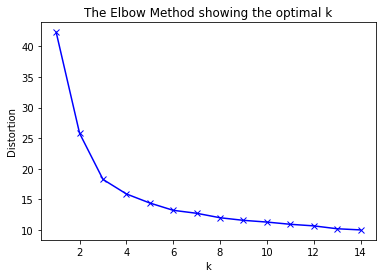

In [22]:
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

No significant distortion change after 4+ clusters. Hence, choose 4 as clusternumber.

In [23]:
kclusters = 4 
# run k-means clustering
kmeanModel = KMeans(n_clusters=kclusters, random_state=0).fit(X)
    
#insert labels and separately stored datas
clustered_data = venue_data.copy()
clustered_data.insert(3, f'Cluster Labels', kmeanModel.labels_)
clustered_data.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Parkwoods,43.753259,-79.329656,1,0,1,0,1,0,4,9,4,4,4
1,Victoria Village,43.725882,-79.315572,1,2,1,0,5,0,4,19,7,18,4
2,"Regent Park, Harbourfront",43.654260,-79.360636,2,49,8,3,49,29,44,46,38,41,33
3,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,3,4,1,0,13,2,6,27,0,34,1
4,Ontario Provincial Government,43.662301,-79.389494,2,45,48,0,50,42,43,49,49,46,33


# Visualize results

## Geospatial map

In [24]:
# create map of Toronto using latitude and longitude values
map_fig = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
kclusters = len(clustered_data["Cluster Labels"].unique())
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(clustered_data["Neighborhood Latitude"], clustered_data["Neighborhood Longitude"], clustered_data["Neighborhood"], clustered_data['Cluster Labels']):
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=f"<i>{str(poi)}, <b> Cluster {str(cluster)}</b></i>",
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_fig)
    
map_fig        

## List top categories for each cluster

In [25]:
def get_top_n_categories(df, n):
    output = df[["Neighborhood", "Neighborhood Latitude", "Neighborhood Longitude"]].copy()
    df = df.drop(["Neighborhood", "Neighborhood Latitude", "Neighborhood Longitude", "Cluster Labels"], axis=1)
    
    #append columns that contain n largest categories
    while n > 0:
        means = df.loc[-1]
        n_largest_category = means[means == max(means)].index[0]
        
        #add n_largest_category to output df
        output[n_largest_category] = df[n_largest_category]
        
        #remove n_largest_category from original df
        df = df.drop(n_largest_category, axis=1)
        
        n-=1
   
    return output

In [26]:
clusters_top_categories = my_dictionary()

for clusterlabel in range(kclusters):
    cluster_data = clustered_data[clustered_data["Cluster Labels"] == clusterlabel].copy()
    cluster_data.loc[-1] = cluster_data.mean(axis=0)
    
    clusters_top_categories.add(f"Cluster {clusterlabel}", get_top_n_categories(cluster_data, 5))

### Visualize cluster components

In [27]:
def get_piedata(data, catColDict):
    data = data.iloc[:, 3:]
    
    #get values
    values = data.loc[-1]
    
    #get labels
    labels = data.columns
    n_max = sum(values)
    labels_with_perc = [label + f", {np.round(data[label].loc[-1]/n_max*100, 2)}%" for label in data.columns]
    
    #get color
    label_colors = [catColDict[category] for category in labels]
    
    return values, labels_with_perc, label_colors

In [28]:
def create_piechart(data, cluster, catColDict):
    values, labels, label_colors = get_piedata(clusters_top_categories[cluster], catColDict)
    
    fig, ax = plt.subplots(figsize =(10, 7))
    plt.pie(values, labels = labels, colors = label_colors)
    ax.set_title(f"Percentage of venues in Neighborhoods of {cluster}", size=17)
    plt.show()
    return

In [29]:
#create colors dictionary
categories = list(clustered_data.columns[4:])
colors_array = cm.rainbow(np.linspace(0, 1, len(categories)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
categories_color_dict = {category: color for (category, color) in zip(categories, rainbow)}

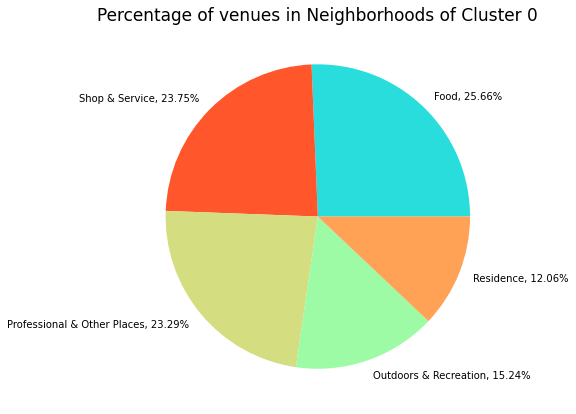

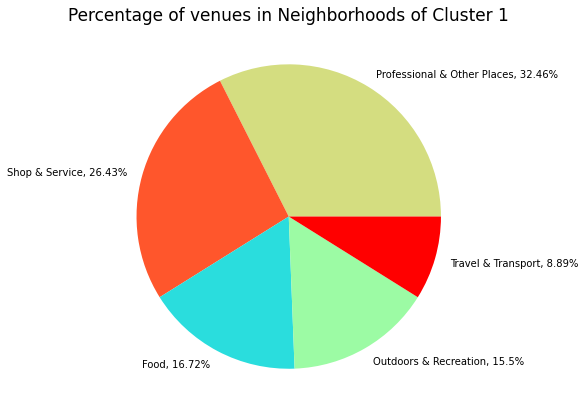

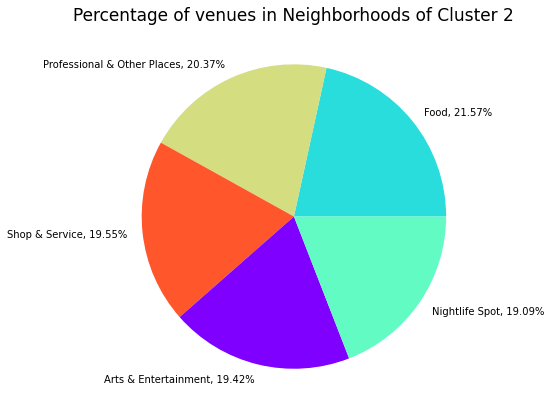

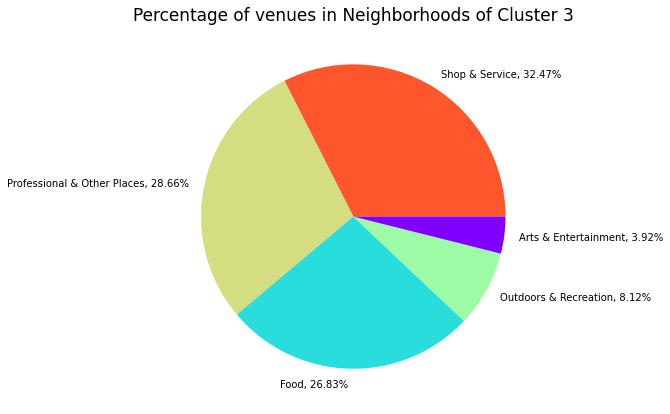

In [30]:
for clusterNr in range(clustered_data["Cluster Labels"].min(), clustered_data["Cluster Labels"].max() + 1):
    create_piechart(clusters_top_categories, f"Cluster {clusterNr}", categories_color_dict)